## Reading the input datasets

In [2]:
import json
import numpy as np
import cv2

jsonTrainFile = "Data/ship/transforms_train.json"

with open(jsonTrainFile, "r") as fp:
    jsonTrainData = json.load(fp)

print(f"Field of view in X direction - train: {jsonTrainData['camera_angle_x']}")
print(f"Number of frames - train: {len(jsonTrainData['frames'])}")

Field of view in X direction - train: 0.6911112070083618
Number of frames - train: 100


In [3]:
first_frame = jsonTrainData["frames"][0]

# transformation matrix and related image
transform_matix = np.array(first_frame["transform_matrix"])
file_name = first_frame["file_path"]

print(transform_matix)  # This the Camera-World transform matrix for the respective image.
print(file_name)  # Respective image file path.
print(f"Rotation {first_frame['rotation']}")

[[-4.65905853e-02  1.75296515e-01 -9.83412623e-01 -3.96426296e+00]
 [-9.98914063e-01 -8.17604642e-03  4.58675772e-02  1.84898108e-01]
 [-9.31322575e-10  9.84481692e-01  1.75487086e-01  7.07411051e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
./train/r_0
Rotation 0.012566370614359171


In [4]:
img = cv2.imread('Data/ship/train/r_0.png')
cv2.imshow('image', img)
cv2.waitKey(0)

-1

---
---


## Rays in Computer Graphics

    r(t) = O + t.d

Here r(t) represent the ray.

- O: Origin vector of the ray (starting point)
- d: Direction unit vector of the ray
- t: Parameter for the ray propagation (like time)



But to do the further processing in our code, we need to first find the corresponding camera coordinate frame x, y, z values to the image pixels. This is where the computer graphics knowledge comes to play.

<center><image src="./imgs/image_plane.png" width="500px"/></center>



We can apply basic trigonometry, to find a relationship between xi, yi values and Xc, Yc values in terms of the f value(we should know this. This is the focal length of the camera)


<center><image src="./imgs/camera_coords.png" width="100"/></center>

In above eqation we assume images start the origin from the top left corner, hence the ox, oy values. With this we can get the Camera Origin vector. But getting the ray origin direction vector is bit more complex.

Theory behind this is pretty simple and [This artical](https://pyimagesearch.com/2021/11/10/computer-graphics-and-deep-learning-with-nerf-using-tensorflow-and-keras-part-1/) have nice simple explanation about it.

But basically what we do is, for a point P in world coordinate system (in homogenius form vector) we need to convert it to camera coordinate frame (This vector can be used to generate the image pixels using the previouly mentioned formula, but in this case we start from there and go backward to get the world coordinates). To do that transformation we need to have `Camera Extrinsic Matrix` for the Camera coordinate system. (Inverse of this matrix is the one given with all the frames in above dataset, so we can directly convert camera coordinates to world coordinates.)

<center><image src="./imgs/coor_transform.png" width="500"/></center>

Here Xw means world coordinates. Xc means Camera world coordinates. Cex means the Camera Extrinsic parameter matrix. This matrix include the transformations required to make the world coordinates convert to camera coordinates. Using this formula we can calculate the world coordinate of a pixel, given its camera coordinate and using that world coordinate vector we can get the directional unit vector.

And also origin of ray is of cause, the translational vector of the world coordinate.

Lets look at basic example on above concepts using our training data.

First lets look at how the cameras are pointed at out object of interest. To check that we can use the vector that goes out of the camera's viewing direction and plot it in a graph with respect to the camera coordinate system origin in world coordinate system.


In [5]:
# Get the transformation matrix of all the frames and get it's rotational component
# Also we need to have the origin of the camera coordinate frame as well

outward_vec = np.array([0,0,-1]).reshape((3, 1)) # This vector goes directly outward from the camera coordinate frame origin

dir_matrices = []
origin_coords = []

for data in jsonTrainData['frames']:
    transform_matix = np.array(data["transform_matrix"])

    r_mat = transform_matix[:3, :3]
    dir_vec = np.dot(r_mat, outward_vec)  # Notice this dot product, If it got messed up everything is meaningless!
    dir_matrices.append(dir_vec)

    o_vec = transform_matix[:3, -1:]
    origin_coords.append(o_vec)


dir_matrices = np.array(dir_matrices)
origin_coords = np.array(origin_coords)


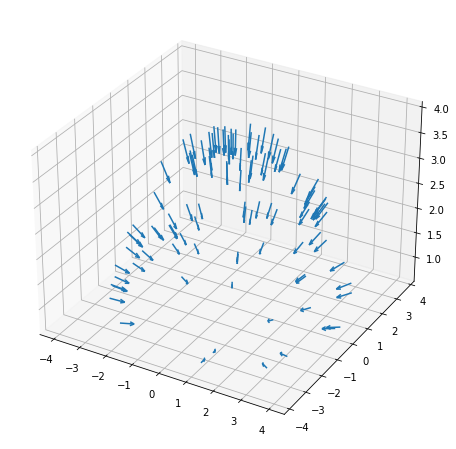

In [6]:
import matplotlib.pyplot as plt

ax = plt.figure(figsize=(12, 8)).add_subplot(projection='3d')

_ = ax.quiver(origin_coords[:, 0],
              origin_coords[:, 1],
              origin_coords[:, 2],
              dir_matrices[:, 0],
              dir_matrices[:, 1],
              dir_matrices[:, 2], length=0.5, normalize=True)
plt.show()

Some important points to note are dimensionality of the vectors. It is important to keep the dimensionality consistent during the calculations or otherwise it may yield unexpected results.

With Above knowledge in mind, now to build rays of the pixels, we need to know the directional vector and the origin vectors with respect to world coordinates. To do that we can obviously use the formulas given above. But the problem is we dont know the xc, yc coordinates of the object. But since we only need to get the directional vector we dont need to know that value. Instead we can use the camera coordinate frame origin to image pixel related geometry to get the required vectors. Check the below image.

<center><image src="./imgs/directional_vectors.png" width="500"/></center>

More details about this can be found in [Here](https://www.scratchapixel.com/lessons/3d-basic-rendering/ray-tracing-generating-camera-rays/generating-camera-rays).

As you can see here, for a given ray we can have the directional vector using the camera view space coordinates. Then we can transform that to world space using the camera2world transform matrix.

In [7]:
def get_rays_for_image(width, height, camera2world_matrix, focal_length):
    # We dont need image because we only consider the pixel coordinate differences to calculate the rays.

    # For a given image below values are contant for all the rays.
    r_mat = camera2world_matrix[:3, :3]
    o_vec = camera2world_matrix[:3, -1:]

    # Since image pixels count start from top left corner, we need to make sure that that issue get solved during directional vector calculation. Hence we reduce those parts from the image x, y coordinates(check the diagram)
    # Since in camera space positive z axis direction is inward to camera we need to make the ray z value to negative to indicate its going outward.
    # Also image y axis and camera space y axis are on different directions. So we need to indicate that by making the y axis negative.
    rays = []
    origins = []
    for i in range(height):
        row_rays = []
        row_origins = []
        for j in range(width):

            vector_x = (j - width*0.5)/focal_length
            vector_y = - (i - height*0.5)/focal_length
            vector_z = - 1

            vector = np.array([vector_x, vector_y, vector_z]).reshape((3, 1))
            dir_vec = np.dot(r_mat, vector)

            row_rays.append(dir_vec)
            row_origins.append([o_vec])
    
        rays.append(row_rays)
        origins.append(row_origins)
    directions = np.array(rays).squeeze()
    ray_origins = np.array(origins).squeeze()
    return ray_origins, directions

In [8]:
t, u = get_rays_for_image(3, 2, r_mat, 2)
print(t)
print(u)

[[[-0.91996354 -0.34553242  0.18513373]
  [-0.91996354 -0.34553242  0.18513373]
  [-0.91996354 -0.34553242  0.18513373]]

 [[-0.91996354 -0.34553242  0.18513373]
  [-0.91996354 -0.34553242  0.18513373]
  [-0.91996354 -0.34553242  0.18513373]]]
[[[ 0.74291172  1.08018969  0.30622295]
  [ 0.91871702  0.6121165   0.30622295]
  [ 1.09452232  0.14404331  0.30622295]]

 [[ 0.65625559  1.0476422  -0.18513373]
  [ 0.83206089  0.57956901 -0.18513373]
  [ 1.00786619  0.11149582 -0.18513373]]]


We can implement the above using matrix operations directly like below. (note vector has been normalized.)

In [9]:
def get_rays_for_image_matrix(width, height, camera2world_matrix, focal_length):

    r_mat = camera2world_matrix[:3, :3]
    o_vec = camera2world_matrix[:3, -1:]

    i, j =  np.meshgrid(
            np.arange(height, dtype=np.float32),
            np.arange(width, dtype=np.float32),
                        indexing='ij')

    vector_x = (j - width*0.5)/focal_length
    vector_y = - (i - height*0.5)/focal_length
    vector_z = - np.ones_like(vector_x)

    dirs = np.stack((vector_x, vector_y, vector_z), axis=2)
    rays = np.sum(r_mat * dirs[:, :, None, :], axis=3)

    origins = np.ones_like(rays)*o_vec.squeeze()

    return origins, rays


In [16]:
t, u = get_rays_for_image_matrix(3, 2, r_mat, 2)
print(t)
print(u)

[[[-0.91996354 -0.34553242  0.18513373]
  [-0.91996354 -0.34553242  0.18513373]
  [-0.91996354 -0.34553242  0.18513373]]

 [[-0.91996354 -0.34553242  0.18513373]
  [-0.91996354 -0.34553242  0.18513373]
  [-0.91996354 -0.34553242  0.18513373]]]
[[[ 0.74291172  1.08018969  0.30622295]
  [ 0.91871702  0.6121165   0.30622295]
  [ 1.09452232  0.14404331  0.30622295]]

 [[ 0.65625559  1.0476422  -0.18513373]
  [ 0.83206089  0.57956901 -0.18513373]
  [ 1.00786619  0.11149582 -0.18513373]]]


In Original NeRF paper, for each ray they have calculated the sample of points which are uniformely distributed within a near and far boundary. Below is an example function to get such sample of points to a single ray.

Idea is this. For any given ray, we assume points are uniformely distributed within the predefined bounds. So we first define number of samples required for the ray and calculate the bin size of range. Then for from each of those bins we randomly select a point. That point and its base bin lower bound can be used to create set of uniform random samples for our purpose. 

In [11]:
import numpy as np
def get_point_samples(near = 0, far = 10, samples=20):

    bins = np.linspace(near, far, samples) # Creating bins for sample point distribution, each sample point will be selected from here

    ran_samples = np.random.uniform(size=samples) # generation random samples in (0, 1) range
    scaled_ran_samples = ran_samples*(far-near)/samples  # scaling the generated samples to bin width range

    ray_samples = bins + scaled_ran_samples  # getting the sample points through the near/far bounds by adding the bin margins to scaled random samples

    return ray_samples

In [12]:
print(get_point_samples())

[ 0.14338579  0.83577339  1.29210506  1.92639851  2.10608159  2.99057762
  3.37645869  4.14920481  4.68348409  4.8958811   5.53126484  6.25565742
  6.68776667  7.07230459  7.45014746  7.89636484  8.60214155  9.08794656
  9.55091131 10.0699019 ]


TBN: This type of sampling can be considered as coarse stratified sampling because values are randomly distributed in the considered near and far bounds. But In NeRF there are 2 types of sampling methods mentioned coarse and fine sampling.

In [13]:
def get_point_samples_matrix(ray_origins, near=0, far=10, sample_size=20):

    bins = np.linspace(near, far, sample_size)

    ran_samples = np.random.uniform(size=(list(ray_origins.shape[:-1])+[sample_size]))  # generate random samples for each point of the input matrix

    scaled_ran_samples = ran_samples*(far-near)/sample_size

    ray_samples = scaled_ran_samples + np.broadcast_to(bins, shape=(list(ray_origins.shape[:-1])+[sample_size]))

    return ray_samples, bins

In [17]:
ray_samples, bins = get_point_samples_matrix(t)
print(t.shape, ray_samples.shape)

(2, 3, 3) (2, 3, 20)


Below is a graphical representation of random samples of pixels generated using above statified sampling function.

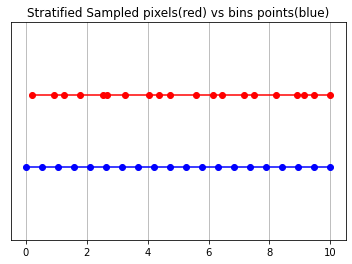

In [98]:
r, b = get_point_samples_matrix(t)
y_vals = np.zeros_like(b)

plt.plot(b, y_vals, 'b-o')
plt.plot(r[0][0], y_vals + 1, 'r-o')

plt.ylim([-1, 2]) # This is to make the plot y axis longer to make the plot clear


plt.title('Stratified Sampled pixels(red) vs bins points(blue)')
ax = plt.gca()
ax.axes.yaxis.set_visible(False)
plt.grid(True)

---

### Volume Rendering

In NeRF model what it output is color density and color value for a given point. Therefore to generate an image from that we need to perform volume rendering operation on NeRF output. What we basically do is taking the cumulative summation of the color values through a ray while taking its color density value as a weightage parameter.


<center><image src="./imgs/volume_rendering_equation.png" width="300"/></center>

Above is the formula of volumetric rendering. 

- C(r): Color of the considering point
- r(t): r(t) = o + td depicts the ray that is considering. 'o' means the origin and 'd' is the directional ray. 't' is the timestep or unit of sampling.
- sigma and 'c' functions depict the volume density and color value at point 't'.


<center><image src="./imgs/transmittance_equation.png" width="300"/></center>

T(r) represent the transmittance of the ray. Which helps to understand how much a ray can go through the 3D space to current considering point.